# Notebook #3: Modelado de los datos

In [1]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Para realizar la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Librería para el acceso a variables y funciones
# -----------------------------------------------------------------------
import sys
sys.path.append("../")
from src import soporte_modelos as sm

- El primer paso consiste en cargar los datos ya estandarizados.

In [3]:
df = pd.read_pickle('../data/transformed/final_rent.pkl')
df.sample(5)

,precio,tipo,exterior,planta,ascensor,tamanio,habitaciones,banios,aire_acondicionado,trastero,terraza,patio,distrito
164,690.0,911.616751,-1.0,3.0,1.0,-0.637969,3.0,1.0,-1.0,-1.0,-1.0,-1.0,841.649557
303,960.0,911.616751,1.0,6.0,1.0,0.151950,3.0,1.0,-1.0,-1.0,-1.0,-1.0,989.781620
360,750.0,911.616751,1.0,3.0,-1.0,-0.400993,3.0,1.0,-1.0,-1.0,-1.0,-1.0,862.491341
65,850.0,911.616751,1.0,3.0,1.0,-0.243010,3.0,1.0,1.0,-1.0,-1.0,-1.0,986.629118
3,815.0,938.211340,1.0,11.0,1.0,-0.440489,2.0,1.0,1.0,-1.0,1.0,-1.0,986.629118


- Para nuestros modelos, utilizaremos el Decision Tree y otros tres modelos de ensamble: el Random Forest, el Gradient Boost y el XGBoost, que se usan en modelos de clasificación y de regresión.

- Nuestro problema es de regresión, por cuanto estamos intentando predecir valores continuos, en este caso, el beneficio. Un valor continuo es un tipo de dato numérico que puede tomar cualquier valor dentro de un rango determinado.

- Los Decision Tree son especialmente efectivos en problemas con interacciones no lineales y datos con diferentes tipos de variables (numéricas y categóricas). Son robustos frente a outliers y pueden gestionar conjuntos con valores faltantes. Sin embargo, son propensos al overfitting. Es entonces cuando podemos recurrir a los modelos de ensamble, para mejorar su estabilidad y precisión.

- El Random Forest puede funcionar mejor cuando tenemos conjuntos de datos grandes o mucho ruido en nuestros datos, pero puede ser menos efectivo para captar variaciones más pequeñas. Es más sencillo configurar los hiperparámetros. Es un modelo de Bagging, donde creamos un bosque (paralelo), no nos quedamos con un sólo árbol, y el resultado es la media de sus medias.

- Con Gradient Boosting, las predicciones suelen ser más acertadas, dado que la secuencia árboles tiende a reducir los errores. Normalmente tarda más para converger. Es más probable tener overfitting. En los modelos de Boosting, se aprende de los datos en la primera iteración (se predice la variable respuesta) pero en las posteriores, aprende de los errores cometidos, que son los que entran en el siguiente árbol, siendo el resultado final el del último árbol.

- La versión optimizada de este último modelo es el XGBoost, que utiliza paralelización (mejora tanto la velocidad como la eficiencia computacional), para maximizar la eficiencia y la precisión general del modelo.
________________________

- Como primer paso, separamos la X y la y de nuestro conjunto de datos.

In [5]:
X = df.drop("precio", axis = 1)
y = df[["precio"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

- Definimos un diccionario de hiperparámetros conjunto para todos los modelos.

In [23]:
parametros_default = {
    "tree": {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    },
    "random_forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    },
    "gradient_boosting": {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 1.0]
    },
    "xgboost": {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

- Antes de probar nuestros modelos, recordemos cómo interpretamos las métricas resultantes, específicamente el R2 y el RMSE, ambas son utilizadas para evaluar la precisión de los modelos de regresión.

- El R2 indica en qué porcentaje las variaciones en el modelo son explicadas por sus variables independientes. Con valores que van de 0 a 1, un valor más cercano a 1 indica un mejor ajuste del modelo.

- Por otro lado, el RMSE mide la magnitud de los errores de predicción, representando la desviación estándar de las diferencias entre los valores predichos y los observados. Un valor más bajo de RMSE indica una mejor predicción. 

- Con esto claro, empezamos las pruebas.

## Decision Tree

In [7]:
modelo_final_tree, df_metricas_tree = sm.probar_modelo(X, y["precio"].values, X_test, y_test, parametros_default["tree"], DecisionTreeRegressor())

Los mejores parámetros para el modelo con DecisionTreeRegressor() son:
    {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.474200,124.855100,28558.947316,168.993927
test,0.466189,121.754233,26626.171353,163.175278


In [29]:
print(f"El precio medio de las viviendas en el conjunto de datos es de: {round(df['precio'].mean())} euros.")

El precio medio de las viviendas en el conjunto de datos es de: 911 euros.


- El resultado es malo, especialmente el R2, que nos está indicando que, las variables del modelo sólamente explican en un 46% los cambios en el modelo.

- En el caso del RSME, tenemos una desviación de aproximadamente 160 euros, que es alta, considerando que la media del conjunto de datos es de 911 euros.

- No tenemos overfitting, es decir, el modelo no está aprendiéndose los datos.

## Random Forest

In [25]:
modelo_final_rf, df_metricas_rf = sm.probar_modelo(X, y["precio"].values, X_test, y_test, parametros_default["random_forest"], RandomForestRegressor())

Los mejores parámetros para el modelo con RandomForestRegressor() son:
    {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.891741,56.615669,5880.115128,76.681909
test,0.885425,56.417197,5714.932018,75.597169


- En este caso, los resultados son muy buenos, con un R2 alto y un RMSE menor. En el caso del R2, quiere decir que, casi el 90% de los cambios en la variable respuesta (precio) pueden ser explicadas por el modelo, mientras que, la otra mitad se debe a factores no capturados por el modelo.

- Veamos la importancia de nuestras variables predictoras, graficándolas para una interpretación más sencilla:

<Axes: xlabel='Importancia', ylabel='None'>

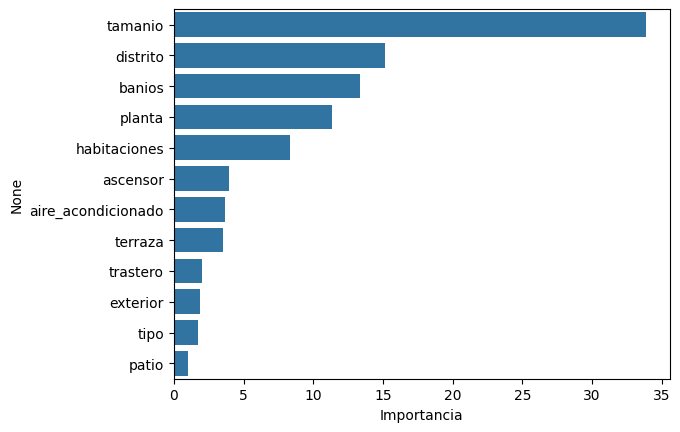

In [35]:
df_importancia_rf = pd.DataFrame((modelo_final_rf.feature_importances_)*100, columns= ["Importancia"], index=X.columns).sort_values(by="Importancia", ascending = False)
sns.barplot(x = "Importancia", y= df_importancia_rf.index, data = df_importancia_rf)

In [33]:
df_importancia_rf

,Importancia
tamanio,33.874574
distrito,15.149950
banios,13.353181
planta,11.364991
habitaciones,8.328020
ascensor,3.967595
aire_acondicionado,3.697299
terraza,3.536429
trastero,2.036250
exterior,1.892613


- Vemos que, con diferencia, el tamaño es la variable predictora más importante, explicando casi un 35% de los cambios.

- Le siguen el distrito, baños y planta, que explican aproximadamente entre el 10 y 15% de los cambios. Las habitaciones representan un 8%.

- Tenemos un grupo que representa entorno al 9%, que son ascensor, aire acondicionado y habitaciones, y otro final que no llega al 2% e incluyen trastero, exterior, tipo y patio.

- Vamos a eliminar este último grupo y probar si obtenemos un mejor resultado.

In [40]:
columnas_a_eliminar = ['trastero', 'exterior', 'tipo', 'patio']

X_train_reducida = X_train.drop(columns=columnas_a_eliminar)
X_test_reducida = X_test.drop(columns=columnas_a_eliminar)

- Ahora reentrenamos al modelo, ajustando ligeramente los parámetros.

In [41]:
modelo_final_rf_v2, df_metricas_rf_v2 = sm.probar_modelo(X_train_reducida, y_train["precio"].values, X_test_reducida, y_test, parametros_default["random_forest"], RandomForestRegressor())

Los mejores parámetros para el modelo con RandomForestRegressor() son:
    {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.521511,120.029167,26902.881317,164.020978
test,0.238737,143.244002,37971.375404,194.862453


- Vemos que, las métricas han empeorado significativamente, así que, no sería este el acercamiento correcto (eliminar variables). Vemos que, además, tenemos muchísimo overfitting.

## Gradient Boost

In [12]:
modelo_final_gb, df_metricas_gb = sm.probar_modelo(X, y["precio"].values, X_test, y_test, parametros_default["gradient_boosting"], GradientBoostingRegressor())

Los mejores parámetros para el modelo con GradientBoostingRegressor() son:
    {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.699888,91.074054,16300.667886,127.674069
test,0.675512,90.912315,16185.260687,127.221306


- Damos un paso atrás respecto a la primera iteración del Random Forest. Vemos que, tanto el R2 como el RMSE han empeorado. Aunque el R2 no es del todo malo, un 0,68, el RMSE es elevado y tendría un efecto negativo elevado sobre los cálculos de rentabilidad.

- No hay overfitting.

## XGBoost

In [13]:
modelo_final_xgb, df_metricas_xgb = sm.probar_modelo(X, y["precio"].values, X_test, y_test, parametros_default["xgboost"], XGBRegressor())

Los mejores parámetros para el modelo con XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) son:
    {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.754118,82.479681,13355.158432,115.564521
test,0.741523,81.849624,12892.678514,113.545931


- Respecto al Gradient Boosting, mejoramos las métricas, con un R2 que explica el 74% de los cambios, sin embargo, se alejan de los resultados obtenidos por el Random Forest, con un RMSE 38 superior.

- Cuando consideramos el impacto sobre la rentabilidad, esto es significativo.

## Modelo elegido

- Dadas las métricas que hemos conseguido, el mejor modelo es Random Forest, con lo cual, guardaremos el objeto.

In [32]:
with open('../transformers/model.pkl', 'wb') as f:
      pickle.dump(modelo_final_rf, f)